In [101]:
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
import os

## data load & preprocessing

In [2]:
myConf = pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf = myConf)\
        .getOrCreate()

21/11/22 13:16:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## step data

In [28]:
step_df = pd.read_excel(os.path.join("steps.xlsx"), names=["data"])

In [37]:
step_list = list(step_df["data"])

In [43]:
temp = []
step_temp = []
for i in range(len(step_list)):
    temp.append(step_list[i])
    if i % 2 != 0:
        step_temp.append(temp)
        temp = []

In [45]:
stepRDD = spark.sparkContext.parallelize(step_temp)

In [67]:
changeStep = stepRDD.map(lambda x: (x[0].split(), x[1]))\
                    .map(lambda x: ("2021.11.18 " + x[0][2], x[1]))\
                    .map(lambda x: (x[0].replace(" ", " 0"), x[1]) if len(x[0]) == 15 else (x[0], x[1]))\
                    .sortByKey(lambda x: x[0])

In [152]:
time_stamp_step = changeStep.map(lambda x: x[0][-5:]).collect()
step_count = changeStep.map(lambda x: x[1]).collect()

/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling


In [197]:
print(time_stamp_step[60])
print(time_stamp_step[61])
print(time_stamp_step[66])
print(time_stamp_step[68])

14:57
15:01
15:41
15:43


## separate

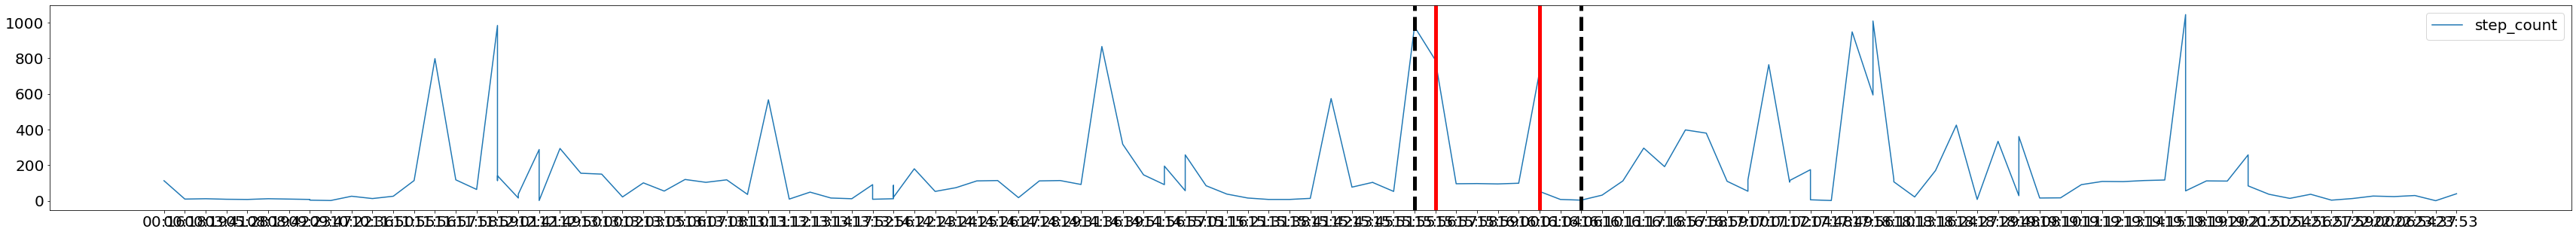

In [198]:
plt.plot(time_stamp_step, step_count, label = "step_count")
plt.rcParams['figure.figsize'] = (60, 5)
plt.rcParams['font.size'] = 20
plt.axvline(60, color='black', linestyle='--', linewidth=5) # 14:57 pm -> 1차 대기실 / 2차 대기실 / 면접 장소 이동
plt.axvline(61, color='red', linestyle='solid', linewidth=5) # 15:01 pm -> 면접 시작
plt.axvline(66, color='red', linestyle='solid', linewidth=5) # 15:41 pm -> 면접 종료
plt.axvline(68, color='black', linestyle='--', linewidth=5) # 15:43 pm -> 종료 후 대기실
plt.legend()

## heart rate data

In [73]:
heart_df = pd.read_excel(os.path.join("hearts.xlsx"), names=["data"])

In [76]:
heart_list = list(heart_df["data"])

In [77]:
temp = []
heart_temp = []
for i in range(len(heart_list)):
    temp.append(heart_list[i])
    if i % 2 != 0:
        heart_temp.append(temp)
        temp = []

In [78]:
heartRDD = spark.sparkContext.parallelize(heart_temp)

In [90]:
changeHeart = heartRDD.map(lambda x: (x[0].split(), x[1]))\
                    .map(lambda x: ("2021.11.18 " + x[0][2], x[1]))\
                    .map(lambda x: (x[0].replace(" ", " 0"), x[1]) if len(x[0]) == 15 else (x[0], x[1]))\
                    .sortByKey(lambda x: x[0])\
                    .combineByKey(lambda value: (value, 1),
                                  lambda x,value: (x[0] + value, x[1] + 1),
                                  lambda x,y: (x[0] + y[0], x[1] + y[1]))\
                    .map(lambda x: (x[0], x[1][0]/x[1][1]))

## plot heart rate

In [103]:
time_stamp = changeHeart.map(lambda x: x[0][-5:]).collect()
heart_rate = changeHeart.map(lambda x: x[1]).collect()

/usr/local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling


## all day long

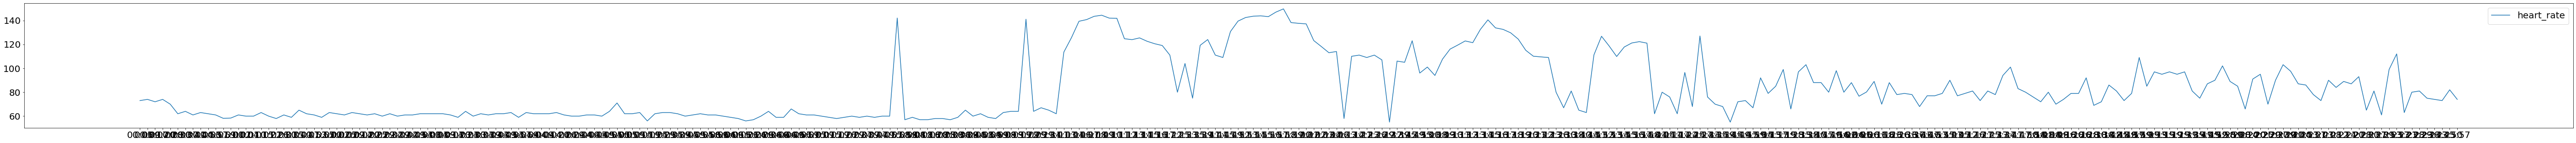

In [122]:
plt.plot(time_stamp, heart_rate, label = "heart_rate")
plt.rcParams['figure.figsize'] = (300, 5)
plt.rcParams['font.size'] = 20
plt.legend()

## 14:00 pm ~ 16:00 pm

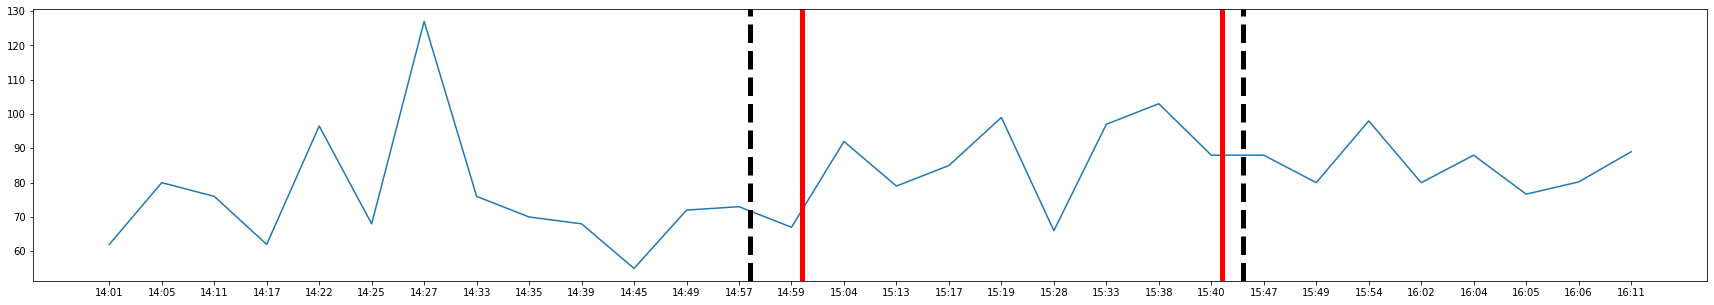

In [212]:
plt.plot(time_stamp[200:230], heart_rate[200:230], label = "heart_rate")
plt.rcParams['figure.figsize'] = (30, 5)
plt.rcParams['font.size'] = 10
plt.axvline(12.2, color='black', linestyle='--', linewidth=5) # 14:57 pm -> 1차 대기실 / 2차 대기실 / 면접 장소 이동
plt.axvline(13.2, color='red', linestyle='solid', linewidth=5) # 15:01 pm -> 면접 시작
plt.axvline(21.2, color='red', linestyle='solid', linewidth=5) # 15:41 pm -> 면접 종료
plt.axvline(21.6, color='black', linestyle='--', linewidth=5) # 15:43 pm -> 종료 후 대기실
plt.show()

## 심박 분석 방법
- 심박과 긴장 사이 관계를 파악할 때
- 단순한 심박수의 높고 낮음뿐만 아니라
- "심박변이도"라 불리는 수치를 사용
- http://www.samsunghospital.com/home/healthInfo/content/contenView.do?CONT_SRC_ID=1607&CONT_SRC=HOMEPAGE&CONT_ID=4845&CONT_CLS_CD=001004
- 이는 심박과 심박 사이의 변화량을 파악하는 것으로
- 피크가 뛴 시점 사이의 시간이 얼마나 변화하는지 보는것
- 일종의 심박 주기의 변화량으로 이해하면되는데
- 이 값이 클수록 -> 심박변이가 불규칙할수록 건강하다고 한다
- 그만큼 심장이 다양한 상황에 알맞게 운동한다는 의미라고하는데
- 이분야는 전문 분야가 아니기 때문에 이정도로 이해했다!

## 그럼 어떤 방법을?
- 아이폰에서 측정된 심박변이도 수치가 존재하긴 하지만
- 지극히 제한적인 시간대만 기록되어있음
- 심박수 또한 매 순간이 기록된 것이 아니기 때문에
- 심박변이도를 사용하는 것은 불가능
- 단순히 심박수를 기반으로 스트레스, 긴장 정도를 파악해보는 것으로 결정

### 심박변이도와 스트레스간의 연관성 증빙
- 전기환, 오주영, 박순희, 정연만, 양동일. (2010). 뇌전도와 심박변이를 이용한 감성 분석 알고리즘에 대한 연구. 한국컴퓨터정보학회논문지 , 15(10), 105-112.
- 최락현, 이동하, 강원석, 손창식. (2015). 휴대용 스트레스 측정기를 활용한 심박수 분석. 한국통신학회 학술대회논문집, (), 527-528.
- 한대석, 정나라, 김동우, 김영언, 이창호. (2007). 심박변이도 측정에 의한 한국인의 스트레스 상태 분석. 스트레스연구, 15(3), 163-169.

### 심박수와 스트레스간의 상관 관계 증빙
- 박진한, 안덕배, 백호종.(2017).심장박동수 측정을 통한 항공교통 관제사의 피로와 스트레스.한국항행학회논문지,21(1),90-98.